In [2]:
import numpy as np
import random, time
from collections import defaultdict
import numba
import copy
import numpy
import math
from solve_model_python import solve_model_python

In [3]:
#translating from reactions to re with a function will automatically create state_index and statelabel below
#this is currently hardcoded but bad practice try and write your own parsing function
################################################################################################################
################################################################################################################
""""create the stoichiometric matrix and the flux vector"""
def create_stoichiometric_matrix(re, y0):
    n_reactions = len(re)
    n_species = len(y0)
    S = np.zeros((n_reactions, n_species))
    A = np.array(S)
    B = np.array(S)
    k = np.zeros(n_reactions)
    for i, (reactants, products, rate) in enumerate(re):
        for j in reactants:
            A[i, j] += 1
        for j in products:
            B[i, j] += 1
        k[i] = rate
    S = (B - A).T

    reactions = []
    for i in re:
        r,p,rate = i
        rct = ""
        cnt = 0
        for j in r:
            if cnt == 0:
                rct += " y[{}] ".format(j)
            else:
                rct += " * y[{}] ".format(j)
            cnt += 1
        rct += " * {}".format(rate)
        reactions.append(rct)

    return S,reactions

In [4]:
""""create the fluxvector using the reactions and stoichiometry"""         
def create_fluxvector(state, reactions, stoichiometry):
    S = np.array(stoichiometry)
    flux_constants = np.zeros(len(reactions))
    flux_dict      = defaultdict(list)
    rev_flux_dict  = defaultdict(list)

    for i, reaction in enumerate(reactions):
        for term in reaction.split('*'):
            term = term.strip()
            try:
                flux_constants[i] = float(term)
            except ValueError:
                if term != '':
                    flux_dict[i].append(int(term.strip('y[]')))
                else:
                    flux_dict[i] = []

    #which propensities are relevant, a product does not react thus, does not need a propensity update
    for key, values in flux_dict.items():
        for value in values:
            rev_flux_dict[value].append(key)

    """p are the flux constants"""
    p = copy.deepcopy(flux_constants)
    
    # """The two dictionaries"""
    flux_dict     = {k:v for k,v in flux_dict.items()}
    rev_flux_dict = {k:v for k,v in rev_flux_dict.items()}

    return S,flux_constants,p, flux_dict, rev_flux_dict

In [122]:
def solve_system(re,y0,state_index,state_label,simulation_number = 100,simulation_time = 24,compilation = True):
    import concurrent.futures
    """the data from the matrix"""
    data = []
    
    """initialize the system by building the model 
    as you defined it BUILD S (stoichiometrix matrix):"""
    S,reactions = create_stoichiometric_matrix(re, y0)
    """build flux vector and map the flux vector"""
    S, flux_constants,p, flux_dict, rev_flux_dict = create_fluxvector(y0, reactions,S)
    # Number of simulations to perform
    """simulate the data N times"""
    for i in range(simulation_number):
        """plug these things into the solver"""
        if compilation == True:
            s, t = solve_model_python(copy.deepcopy(y0) ,S, flux_constants, copy.deepcopy(p), flux_dict, rev_flux_dict, simulation_time)
        else:
            s, t = solve_model_python(copy.deepcopy(y0) ,S, flux_constants, copy.deepcopy(p), flux_dict, rev_flux_dict, simulation_time)     
        s = np.vstack(s)
        if t[-1] != math.inf:
            """store the data"""
            simdata = {}
            for j in range(len(state_index)):
                simdata[state_label[j]] = s[:, state_index[j]]
            data.append(stochastic_simulation(t,simdata,state_index,state_label))
    return data       

In [100]:
class stochastic_simulation:
    def __init__(self,time,data,state_index,state_label):
        """the time and the dataset"""
        self.time = time
        self.data = data
        
        """the state index and the state label"""
        self.state_index = state_index
        self.state_label = state_label
        
    def select_datapoints(self,selected_timepoints = [12,24,36,60]):
        indices = []
        for i in selected_timepoints:
            index   = numpy.argmin((numpy.array(self.time) - i)**2)
            indices.append(index)
        
        """select the datapoints corresponding to timepoints"""
        self.selected_datapoints = {i:[] for i in self.data.keys()}
        
        """get the datapoints"""
        for i in indices:
            for state,data in self.data.items():
                self.selected_datapoints[state].append(data[i])
                
    def plot(self,targetlist = [2,3]):
        import matplotlib.pyplot as plt
        plt.figure(figsize = (8,4))
        for j in range(len(state_index)):
            if j in [1]:     
                plt.subplot(1,2,1)
                plt.step(self.time, self.data[self.state_label[j]], alpha=0.5,label = self.state_label[j])
                plt.ylabel('Gene state',size= 14) 
                plt.tight_layout()
                plt.legend(fancybox = True)
                
            if j in targetlist: 
                plt.subplot(1,2,2)
                plt.plot(self.time, self.data[self.state_label[j]], alpha=0.5,label = self.state_label[j])        
                plt.ylabel('Species count',size= 14)
                plt.xlabel('Time',size= 14)
                plt.legend(fancybox = True)
        
        plt.tight_layout()
        """plot the data in a figure"""
        plt.legend(fancybox = True)
        plt.show()

In [132]:
""" 1)This is where all the things that need to happen should happen i.e. define system and build equations"""
"""2) parse the reactions into a format with index placeholders as these numbers directly represents the stoichiometric matrix and the flux vector
    Define reaction system: read as ((reactants),(products),rate)"""
re = [((0,),(1,), 1),
      ((1,),(0,), 1),
      ((1,),(1,2,), 100),
      ((2,),(), 0.3)]

"""3a) #define states and set initial conditions"""
states = 3
"""3b)iniital conditoins"""
y0 = numpy.array([0 for i in range(states)],dtype = np.float64)
y0[0] = 0
y0[1] = 1
y0[2] = 0

"""3c) deinfe the labels that correspond to each index i.e. species names"""
plot        = False
state_index = range(len(y0))
state_label = ["OFF","ON","mRNA"]
#this quantifies how long the computer spends in each operation
import cProfile

#run the script and benchmark it 
cProfile.run('data  = solve_system(re,y0,state_index,state_label)', sort='cumtime')

"""
#run the script by just running it
#solve the system, state index and label needed for plotting
data  = solve_system(re,y0,state_index,state_label)
#create simulation objects
merged_data = collect_data(data)
#plot the correlations
plot_correlation(merged_data)
"""

         3837045 function calls in 6.218 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    6.218    6.218 {built-in method builtins.exec}
        1    0.001    0.001    6.218    6.218 <string>:1(<module>)
        1    0.028    0.028    6.217    6.217 2712774700.py:1(solve_system)
      100    3.854    0.039    5.888    0.059 solve_model_python.py:4(solve_model_python)
   450974    0.316    0.000    1.251    0.000 fromnumeric.py:53(_wrapfunc)
   225487    0.186    0.000    0.915    0.000 fromnumeric.py:2512(cumsum)
   225487    0.159    0.000    0.680    0.000 fromnumeric.py:1332(searchsorted)
   225487    0.520    0.000    0.520    0.000 {method 'cumsum' of 'numpy.ndarray' objects}
   225487    0.334    0.000    0.334    0.000 {method 'searchsorted' of 'numpy.ndarray' objects}
      100    0.081    0.001    0.296    0.003 shape_base.py:219(vstack)
   225487    0.251    0.000    0.251    0.000 

'\n#run the script by just running it\n#solve the system, state index and label needed for plotting\ndata  = solve_system(re,y0,state_index,state_label)\n#create simulation objects\nmerged_data = collect_data(data)\n#plot the correlations\nplot_correlation(merged_data)\n'

[   0.       19.3      62.7099  136.1571  228.4179  343.1579  462.7796
  593.5344  729.6819  864.9779  969.2339 1091.0571 1205.1539 1323.6684
 1438.1211 1540.5851 1630.3211 1745.8811 1853.64   1928.6675 1992.4804
 2092.5556 2157.2024 2237.4    2365.5699 2520.9504 2618.4979 2726.5211
 2800.4059 2877.4584 2911.1044 3017.0339 3111.7676 3152.4704 3230.8544
 3278.8856 3351.0675 3408.55   3448.2771 3529.6096 3600.7636 3663.8196
 3722.07   3762.8136 3799.2459 3857.3884 3878.7244 3784.4356 3819.1404
 3788.1536 3763.85   3664.4364 3631.4216 3526.5771 3412.2171 3305.2659
 3168.2811 3049.1651 2942.3796 2922.0704 2931.0744 2935.9875 2964.2744
 2922.8491 2875.45   2838.95   2815.3604 2828.3064 2823.7179 2812.7691
 2799.7211 2819.1339 2817.5179 2878.1056 2895.6859 2895.1219 2989.78
 3083.8076 3137.6171 3174.6576 3231.2211 3272.1036 3294.92   3329.8364
 3365.9036 3453.1896 3491.0716 3581.4284 3591.41   3677.9979 3732.7259
 3793.07   3788.7611 3903.8824 3965.5956 4002.1979 4017.8476 4038.4971
 4004.96

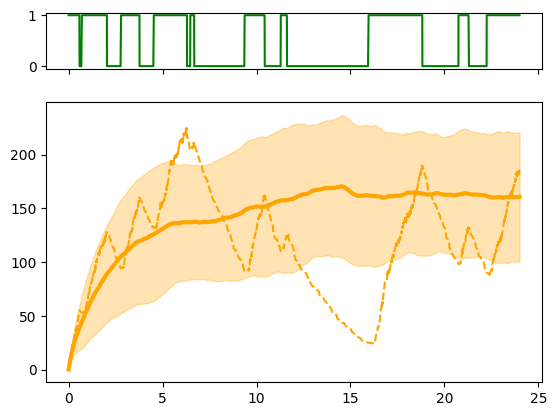

In [133]:
fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 5]})
target_times  = np.arange(0, 24.1, 0.1)
mRNA_compiled = np.zeros((len(data), len(target_times)))
                         
for i in range(0, len(data)):
    time_array = np.asarray(data[i].time)

    # Compute the absolute differences between target_times and time_array
    diffs = np.abs(time_array[:, np.newaxis] - target_times)

    # Find the indices of the closest times
    closest_indices = np.argmin(diffs, axis=0)
    
    mRNA_data = np.asarray(data[i].data['mRNA'])[closest_indices]
    mRNA_compiled[i,:] = mRNA_data
    
    if i == 0:
        axs[0].plot(time_array, data[i].data['ON'], color = 'green', linestyle = '-')
        axs[1].plot(time_array, data[i].data['mRNA'], color = 'orange', linestyle = '--')
        

# Calculate the mean and variance
mean_mRNA = np.mean(mRNA_compiled, axis=0)
variance_mRNA = np.var(mRNA_compiled, axis=0)
print(variance_mRNA)
print(variance_mRNA[-1]/mean_mRNA[-1])

# Plot the mean mRNA
axs[1].plot(target_times, mean_mRNA, color='orange', linewidth = 3)

# Fill between mean ± standard deviation
axs[1].fill_between(target_times, 
                    mean_mRNA - np.sqrt(variance_mRNA), 
                    mean_mRNA + np.sqrt(variance_mRNA), 
                    color='orange', alpha=0.3, label='Variance Range')



fig.savefig('stable_degradation.svg')



29.958908527102903


C:\Users\verha\AppData\Local\Temp\ipykernel_19216\3401850441.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(mRNA_compiled[:, -1], ax = ax)


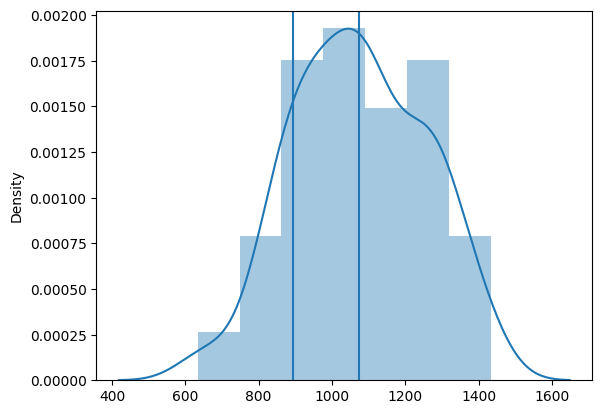

In [131]:
import seaborn as sns
fig, ax = plt.subplots()

sns.distplot(mRNA_compiled[:, -1], ax = ax)
ax.axvline(mean_mRNA[-1])
ax.axvline(mean_mRNA[-1] - np.sqrt(variance_mRNA[-1]))
print(variance_mRNA[-1]/mean_mRNA[-1])

Shape of mRNA data for simulation 0: (1849,)
Shape of mRNA data for simulation 1: (1248,)
Shape of mRNA data for simulation 2: (1918,)
Shape of mRNA data for simulation 3: (1503,)
Shape of mRNA data for simulation 4: (1940,)
Shape of mRNA data for simulation 5: (2655,)
Shape of mRNA data for simulation 6: (1826,)
Shape of mRNA data for simulation 7: (2401,)
Shape of mRNA data for simulation 8: (2643,)
Shape of mRNA data for simulation 9: (2487,)
Shape of mRNA data for simulation 10: (2753,)
Shape of mRNA data for simulation 11: (2607,)
Shape of mRNA data for simulation 12: (2046,)
Shape of mRNA data for simulation 13: (2401,)
Shape of mRNA data for simulation 14: (1065,)
Shape of mRNA data for simulation 15: (2011,)
Shape of mRNA data for simulation 16: (1801,)
Shape of mRNA data for simulation 17: (2261,)
Shape of mRNA data for simulation 18: (1993,)
Shape of mRNA data for simulation 19: (2118,)
Shape of mRNA data for simulation 20: (1606,)
Shape of mRNA data for simulation 21: (1402,

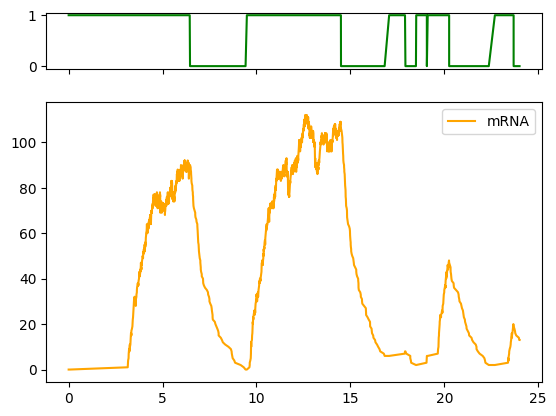

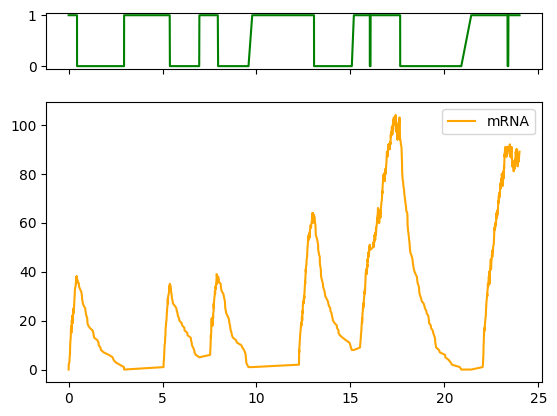

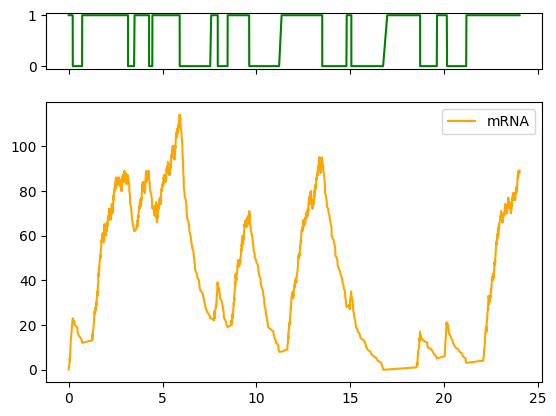

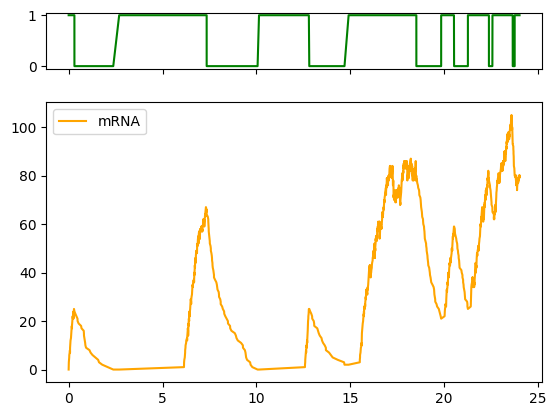

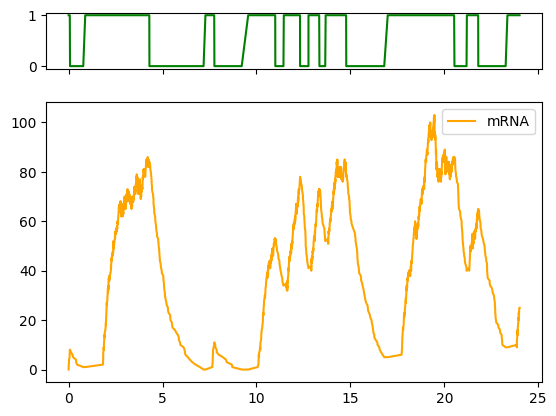

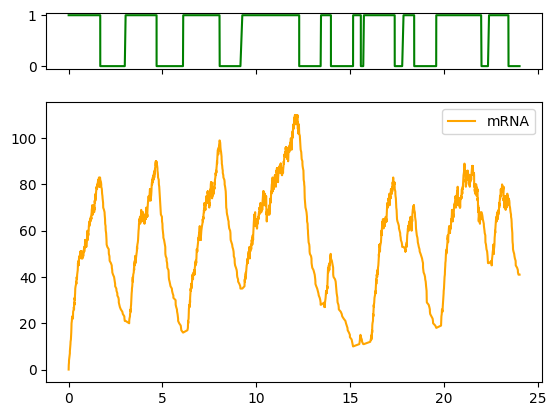

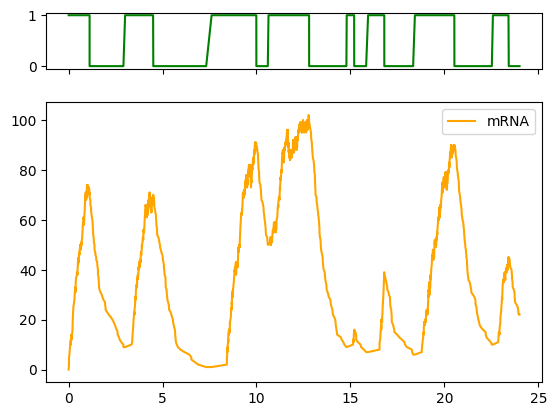

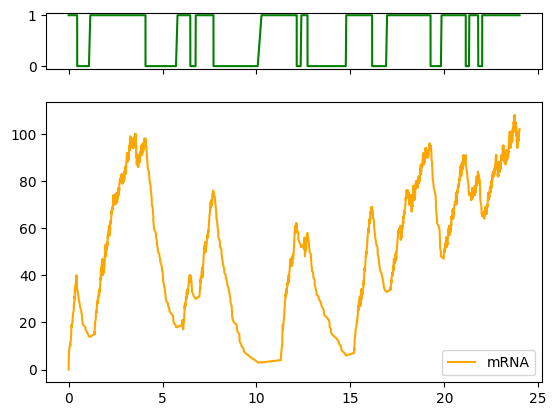

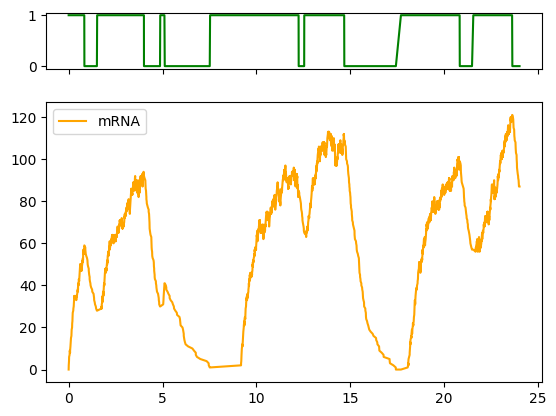

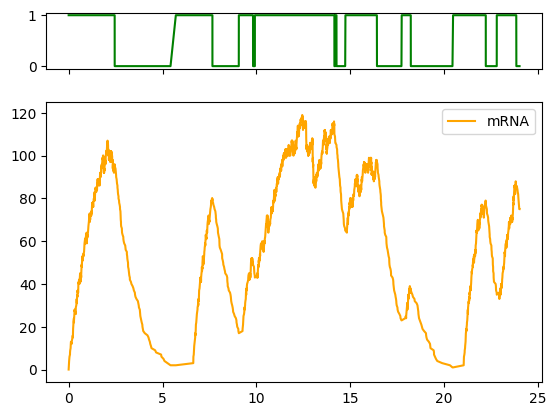

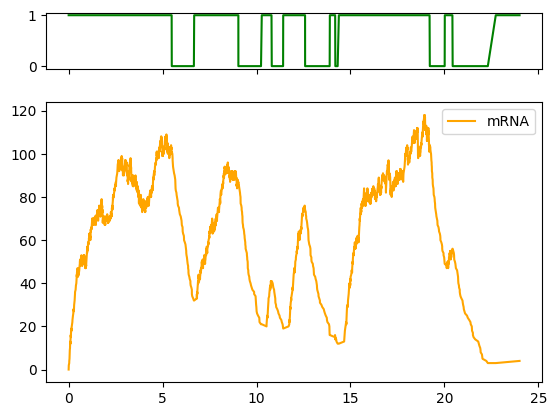

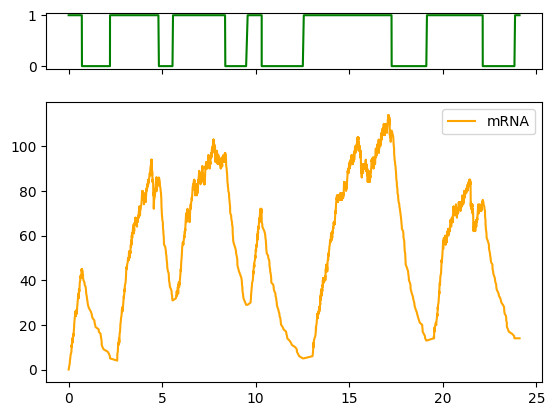

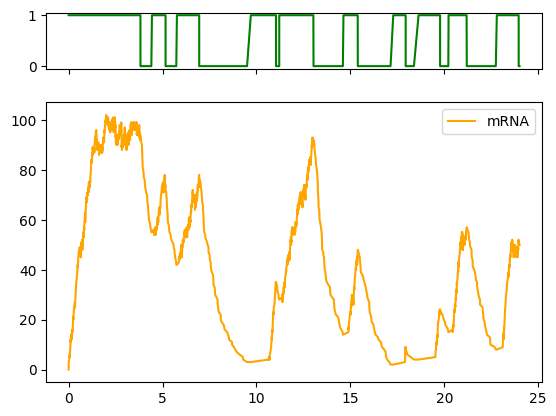

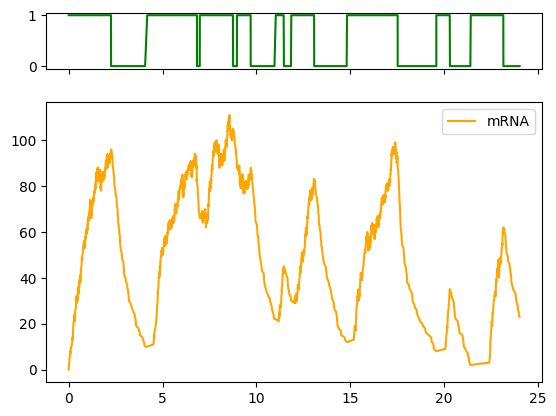

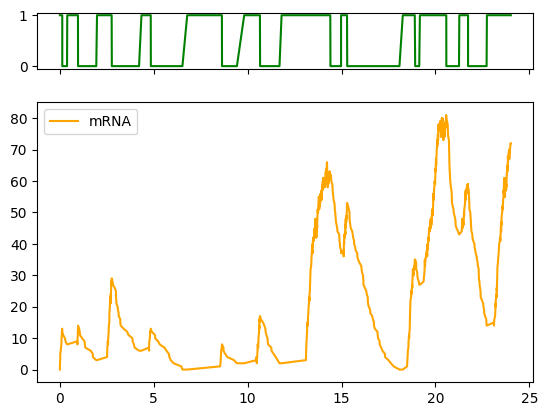

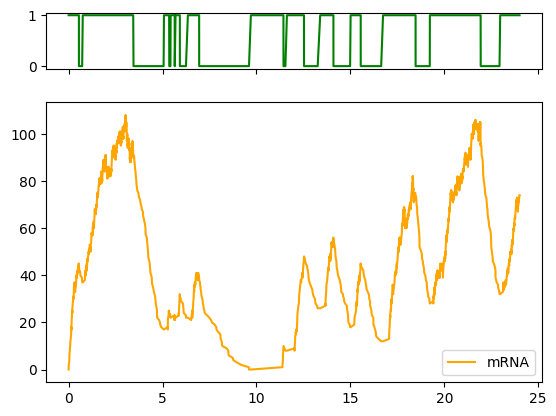

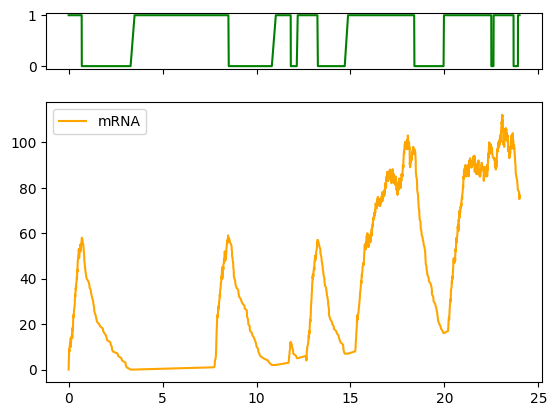

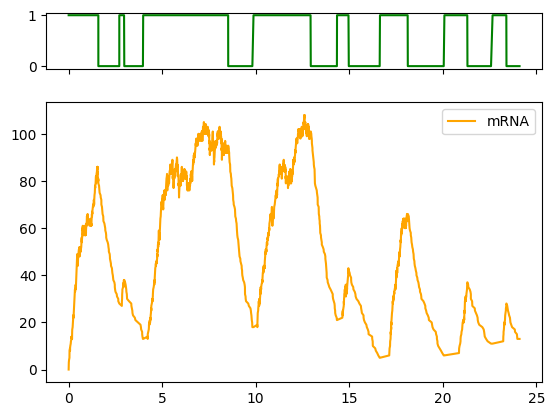

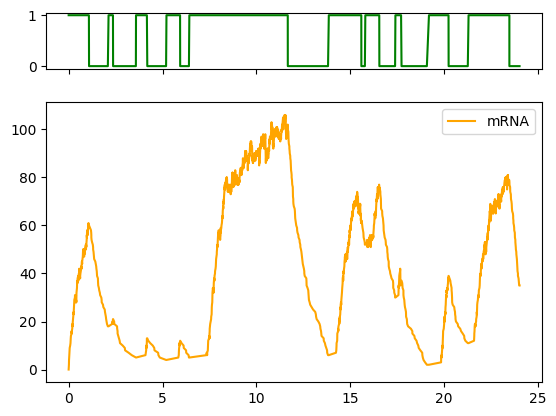

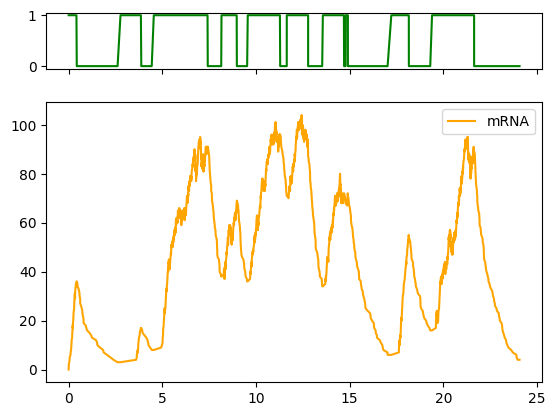

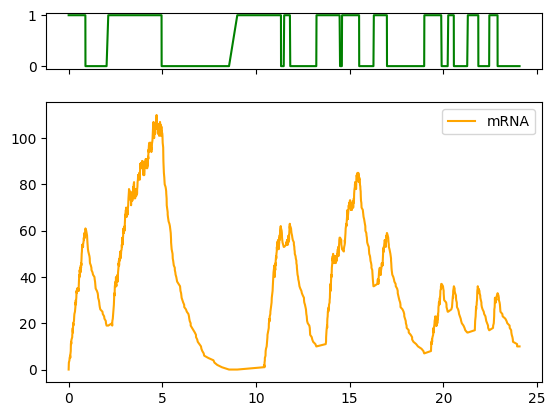

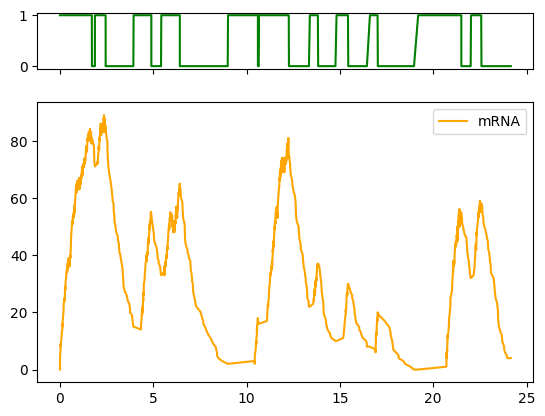

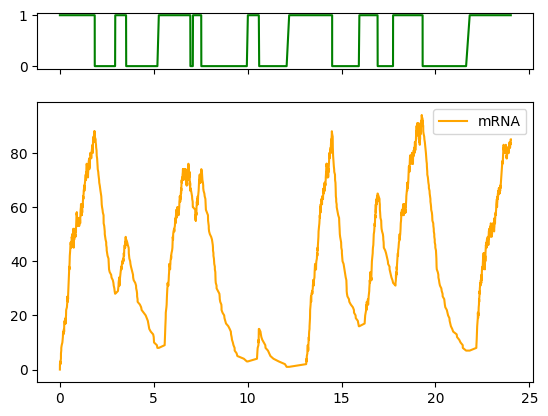

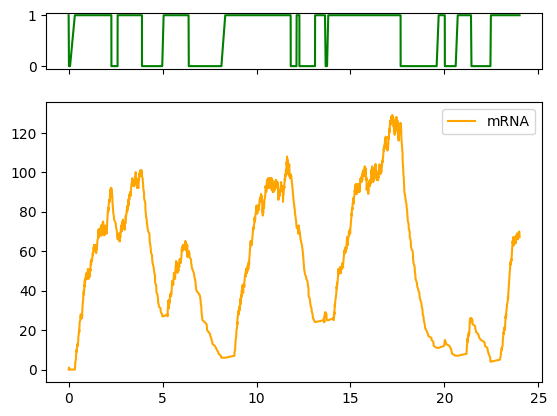

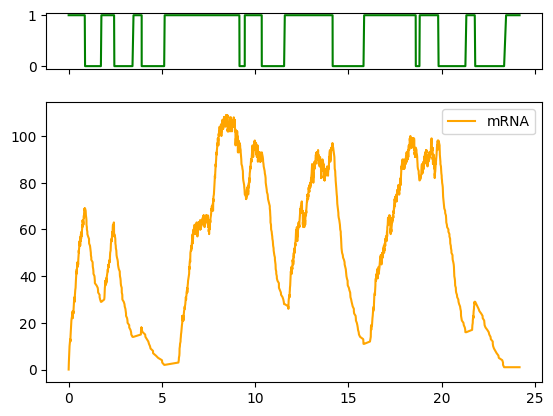

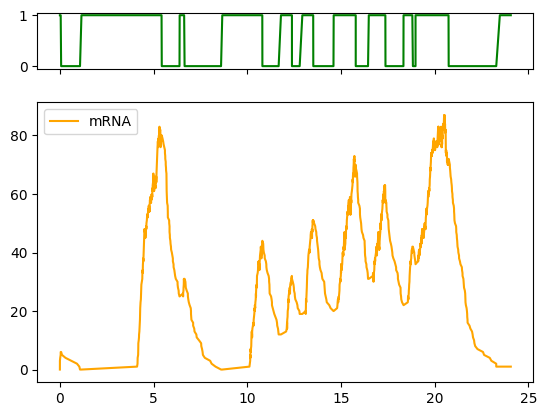

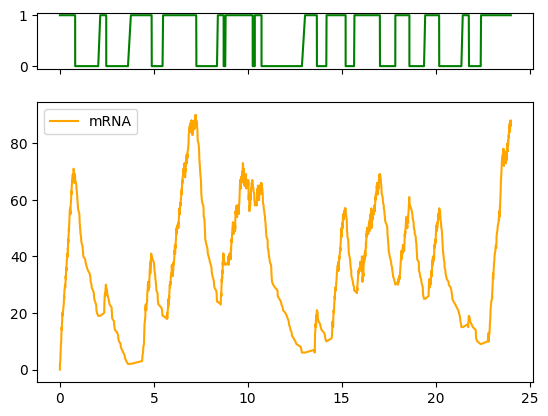

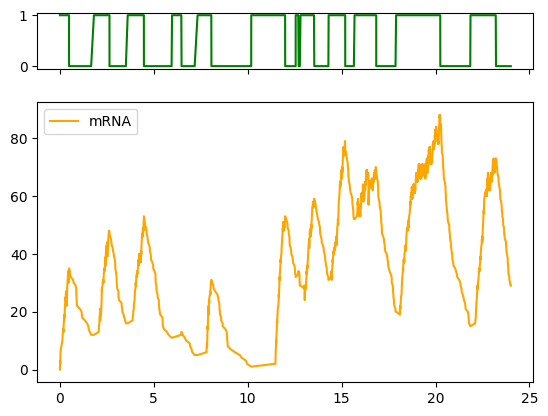

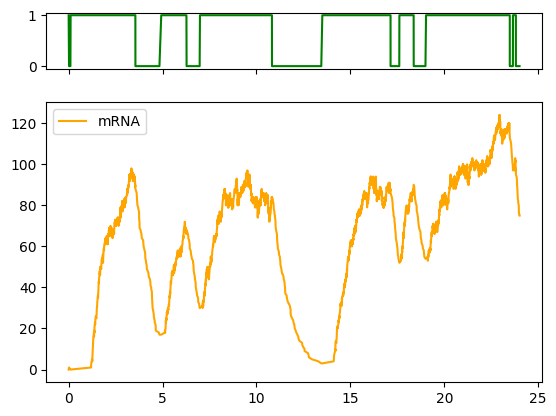

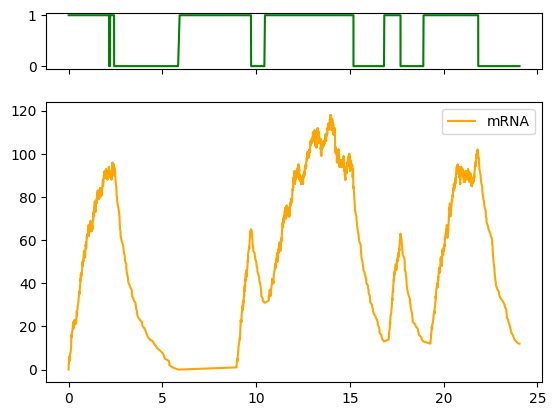

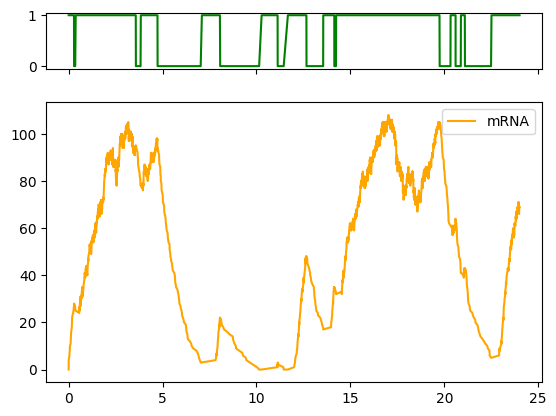

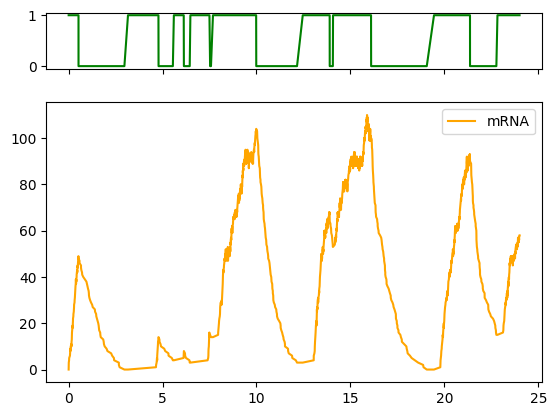

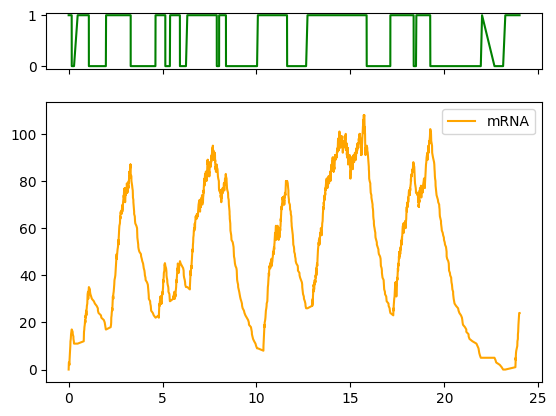

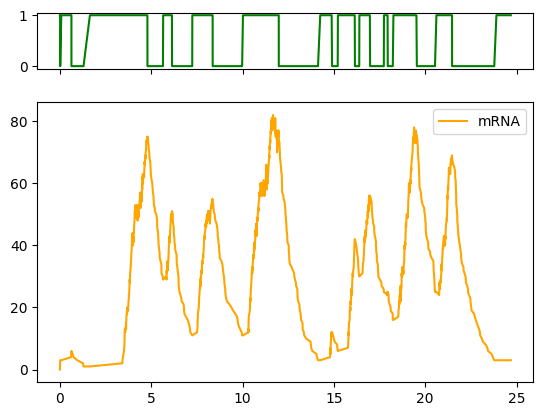

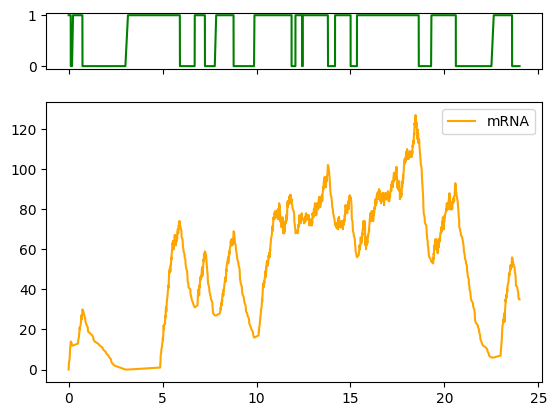

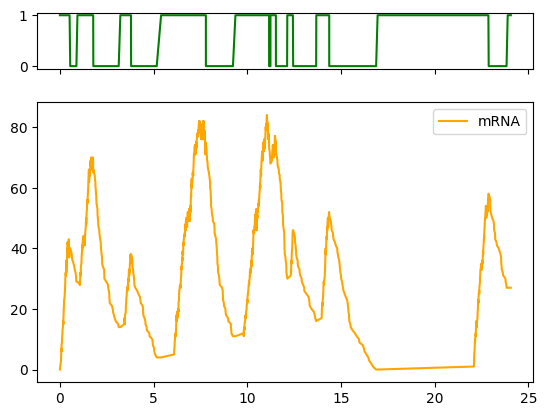

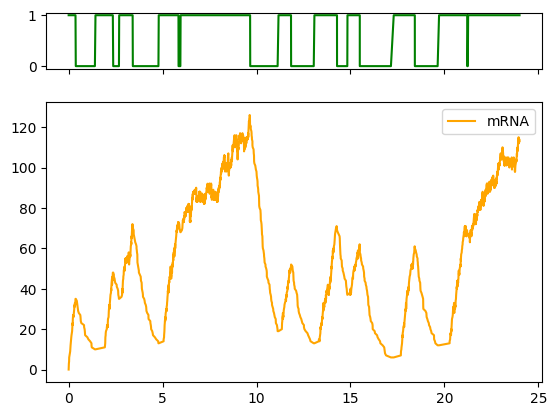

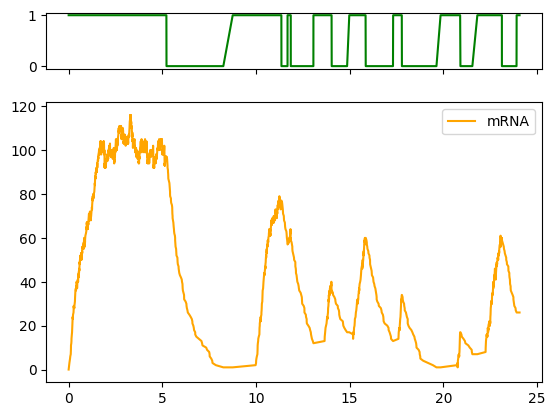

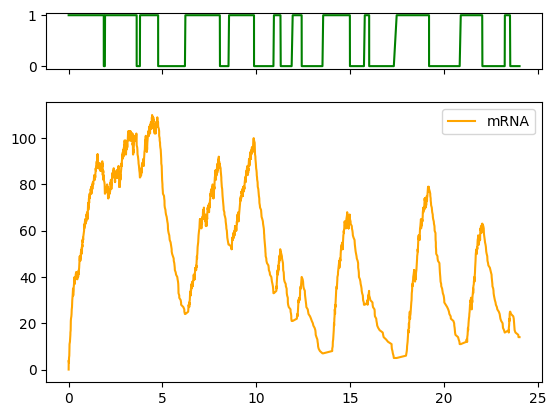

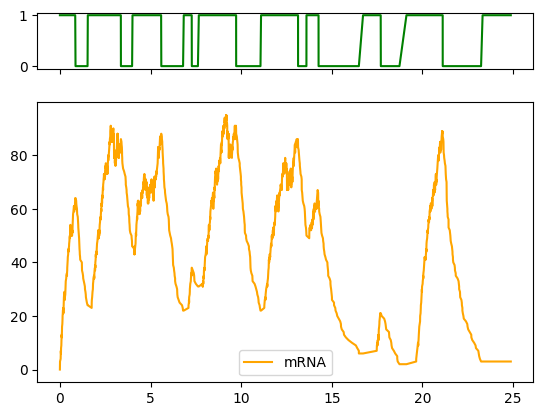

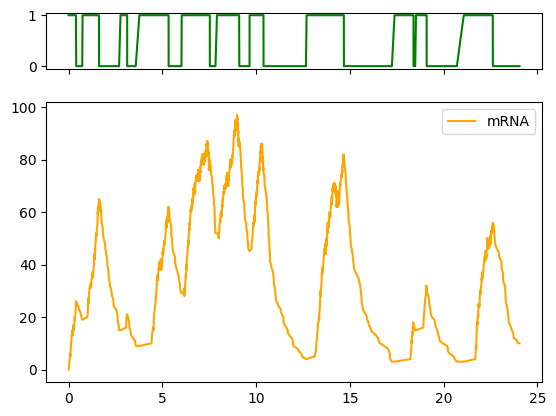

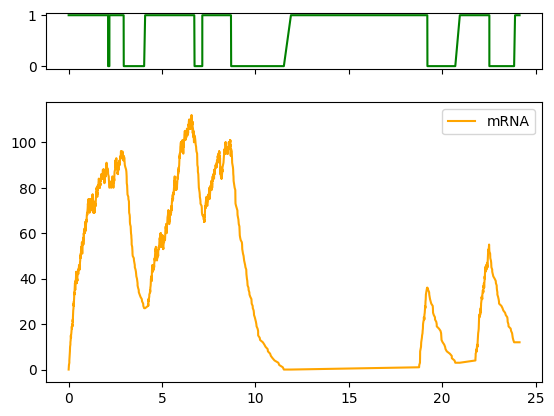

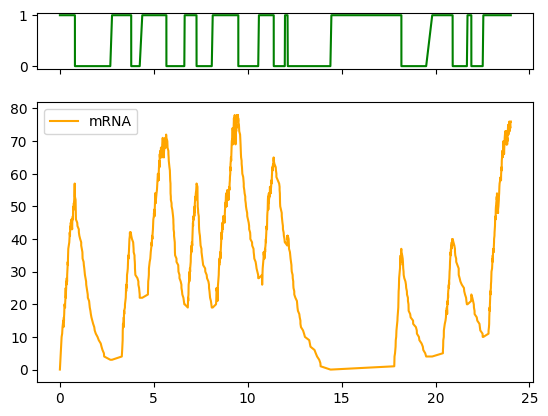

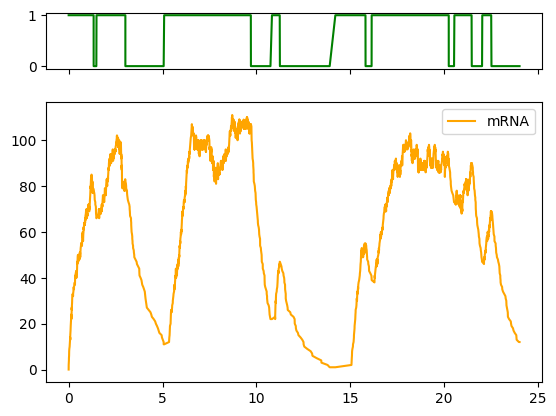

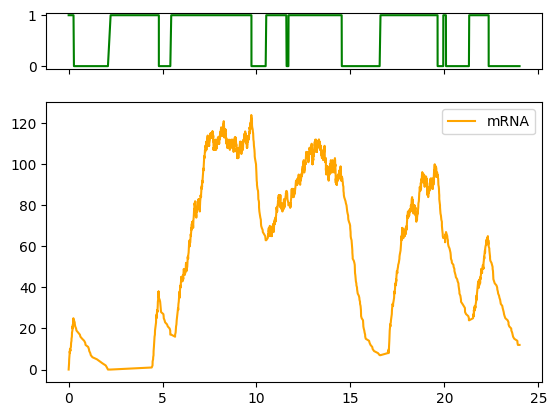

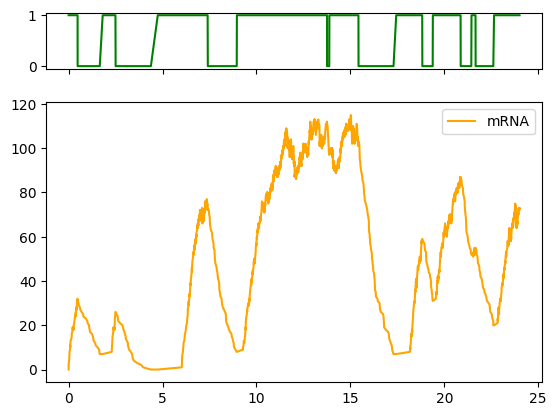

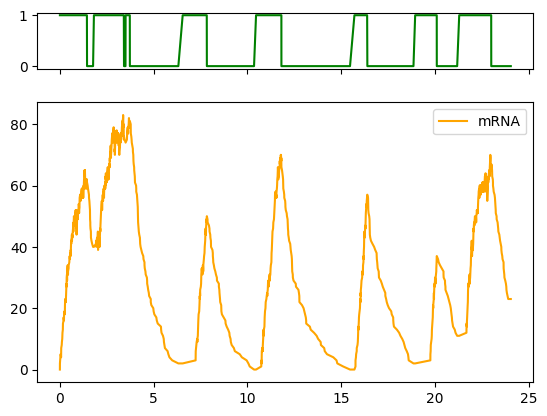

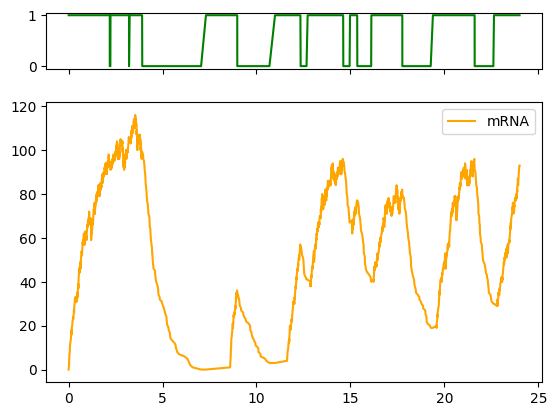

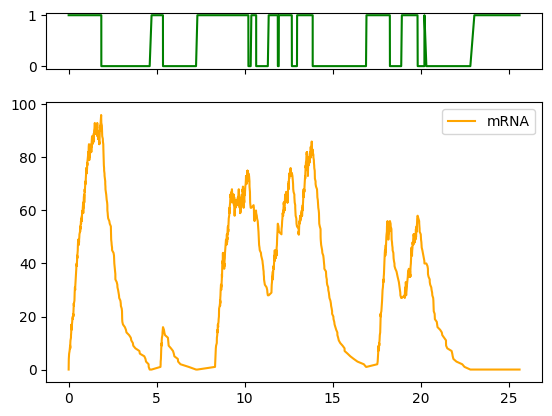

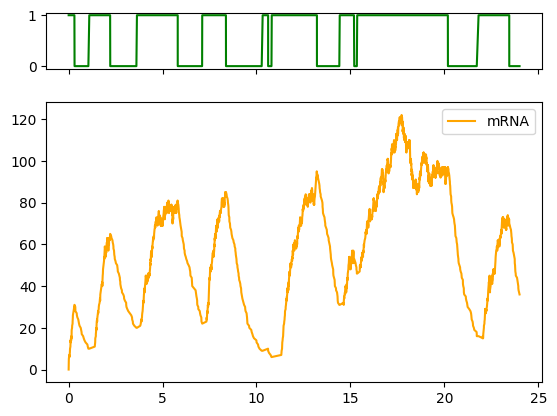

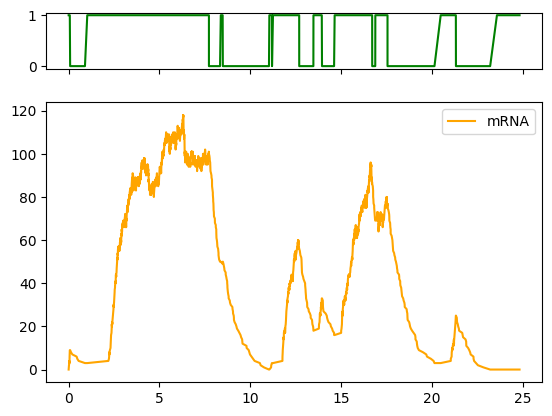

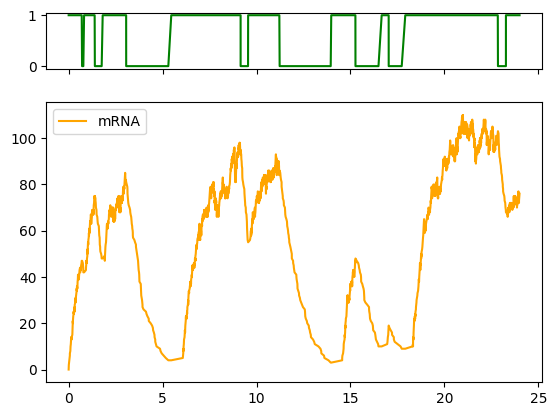

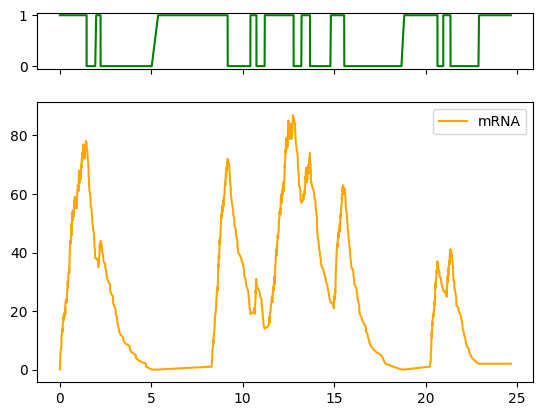

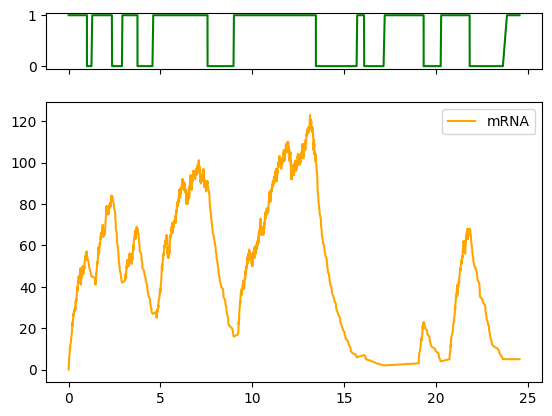

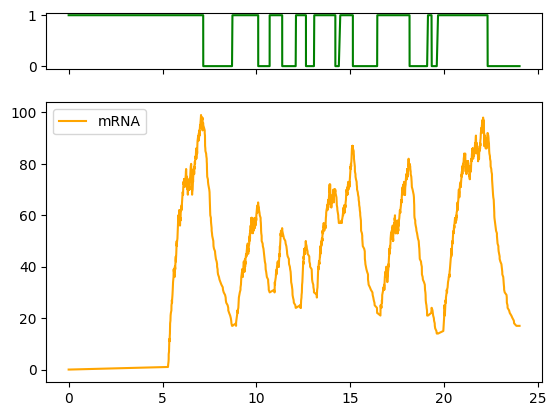

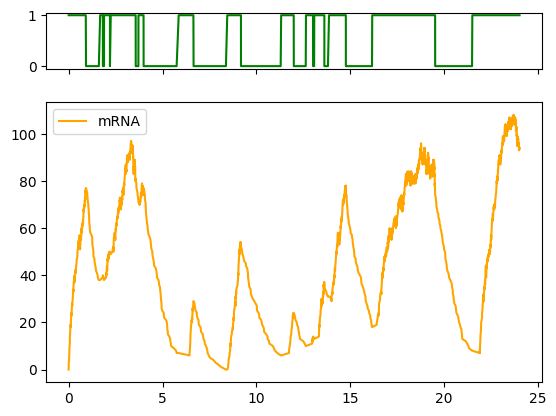

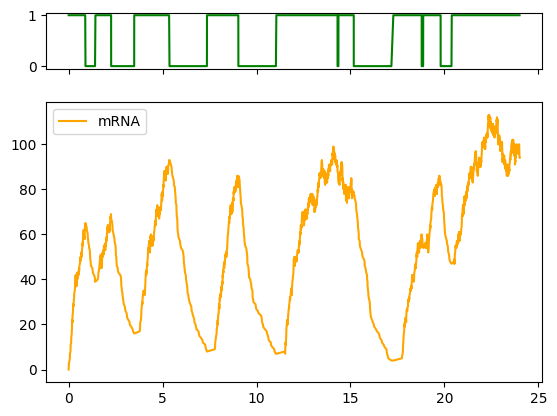

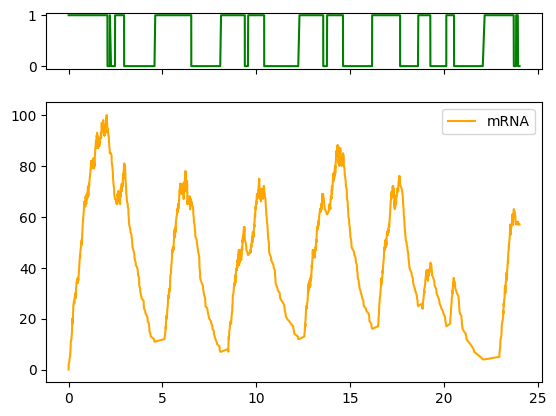

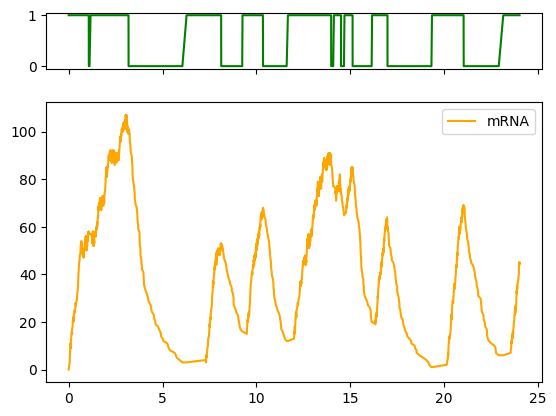

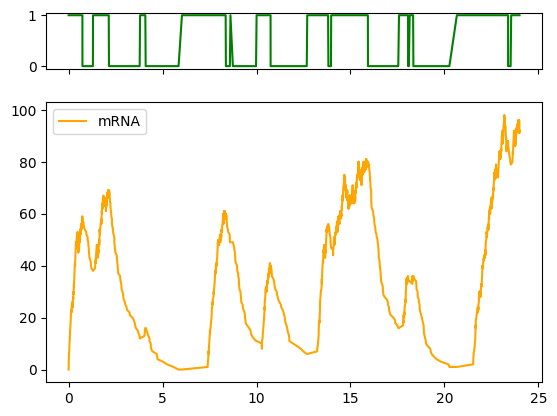

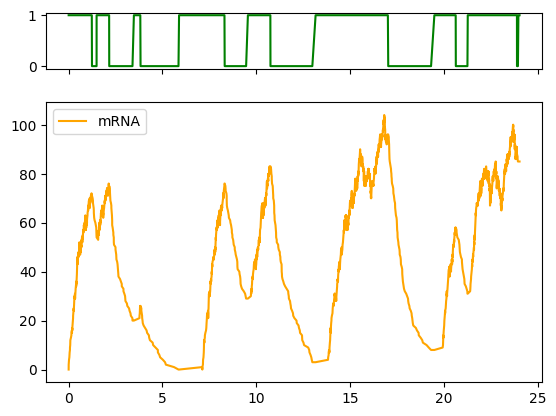

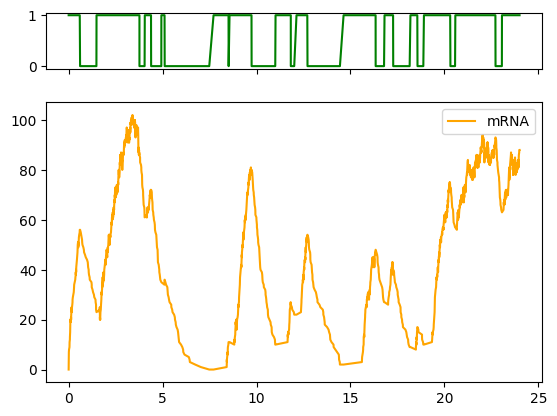

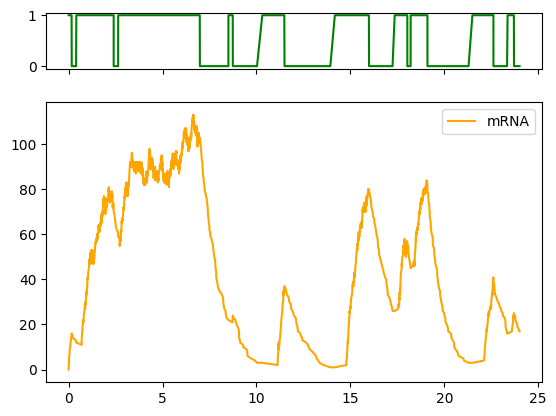

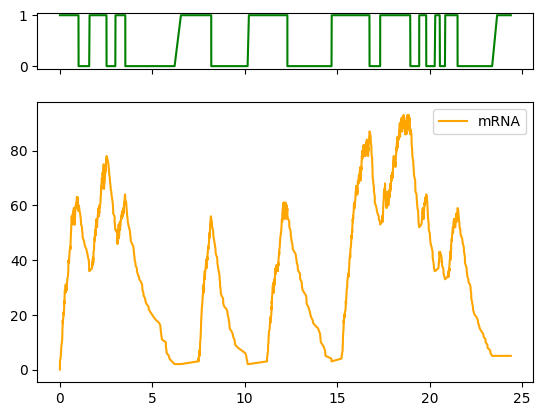

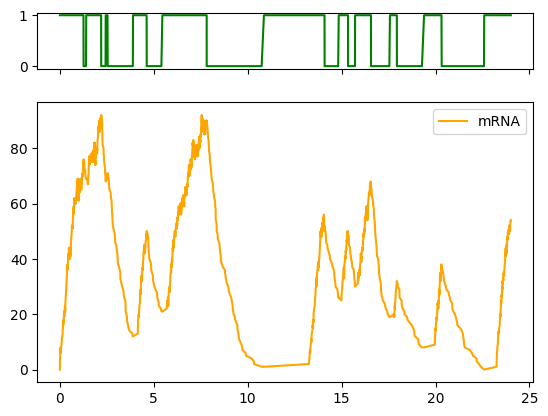

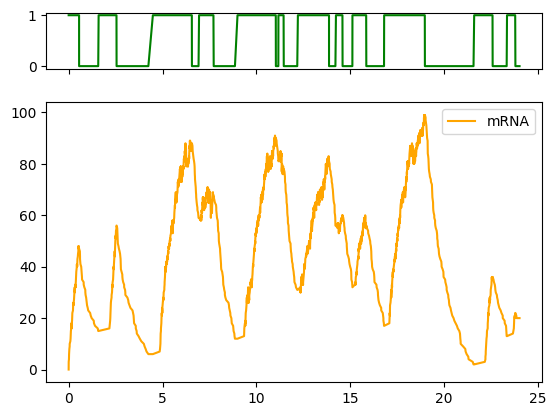

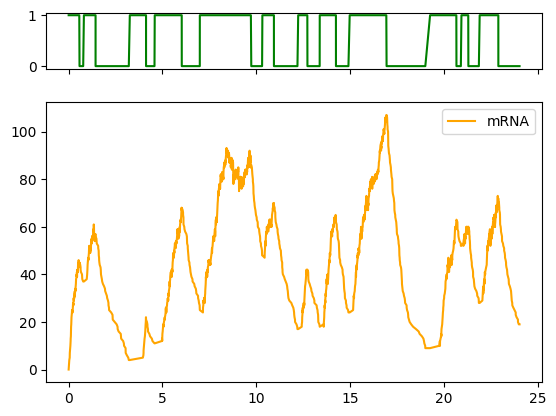

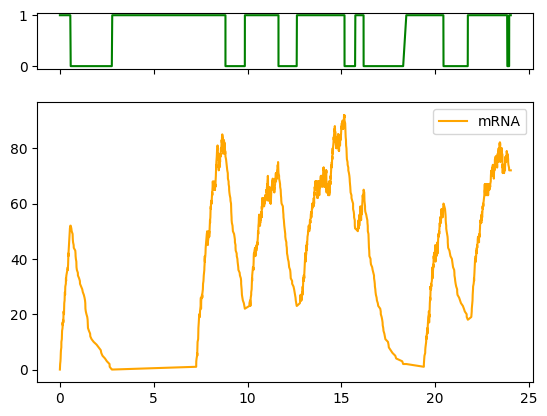

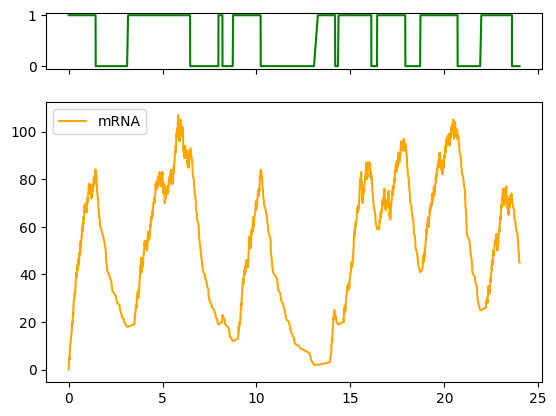

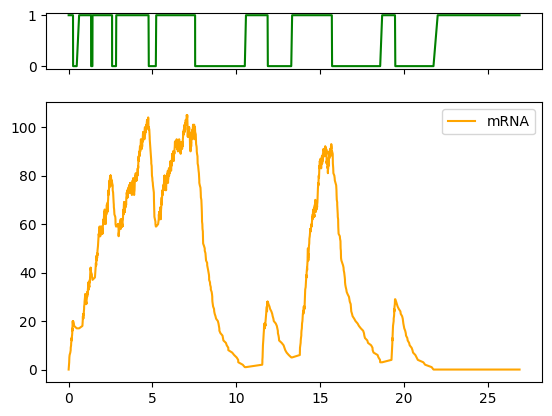

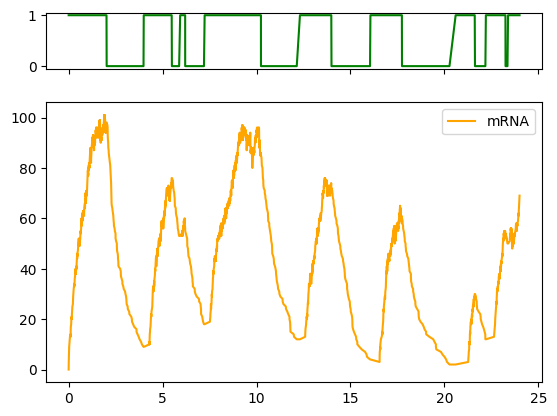

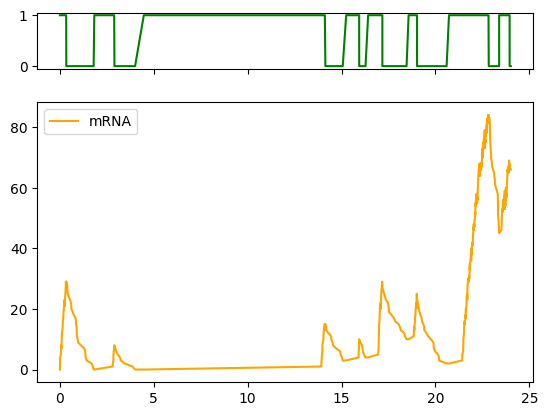

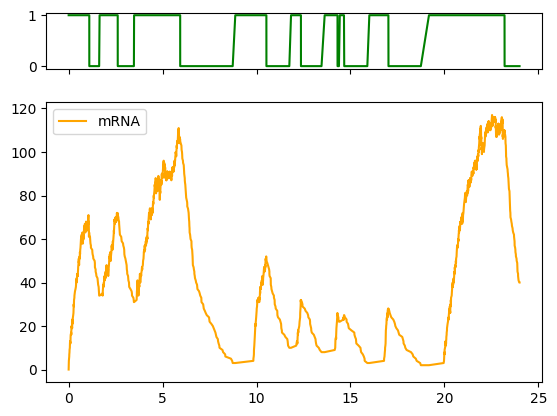

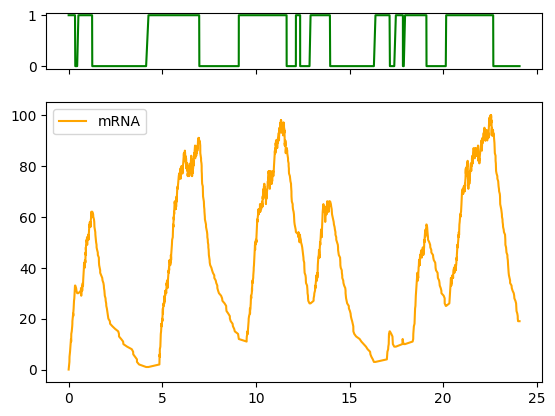

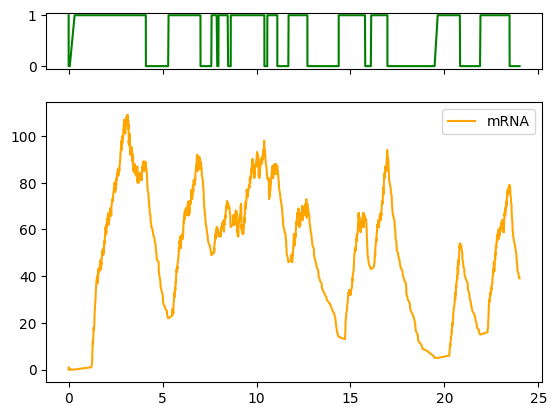

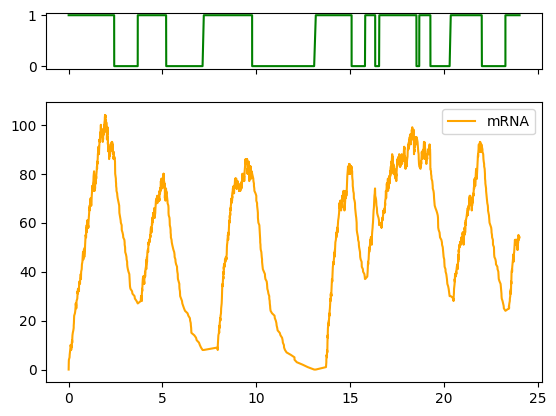

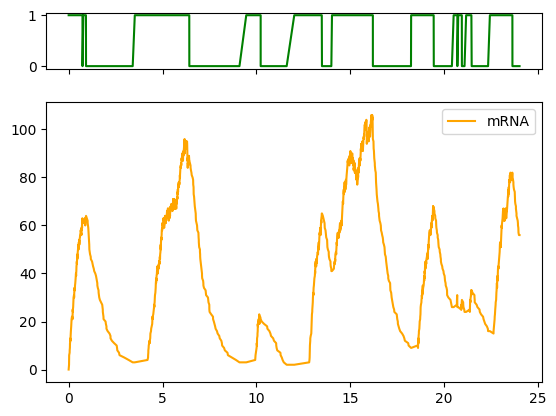

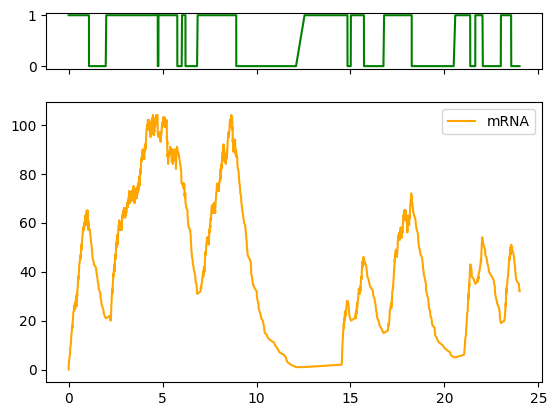

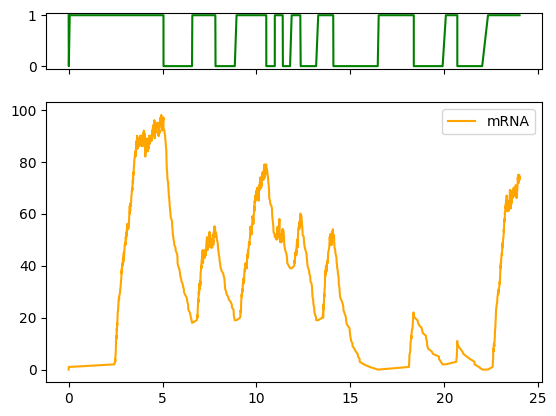

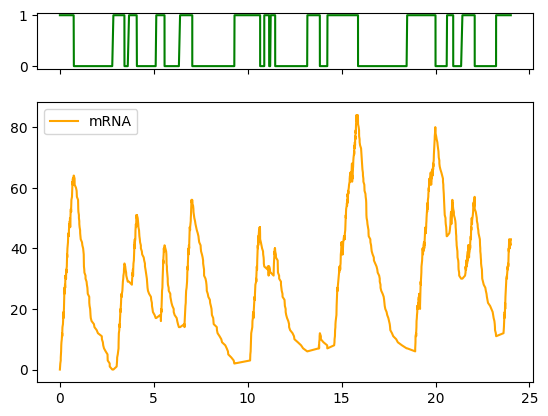

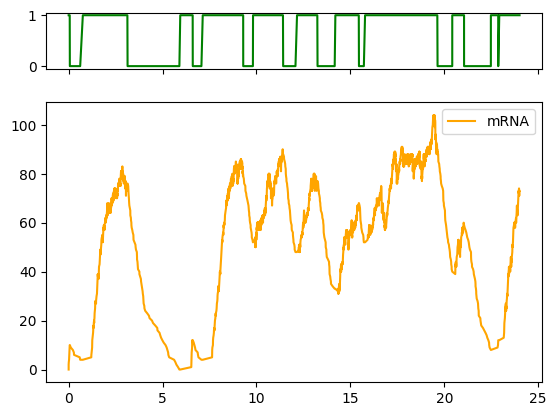

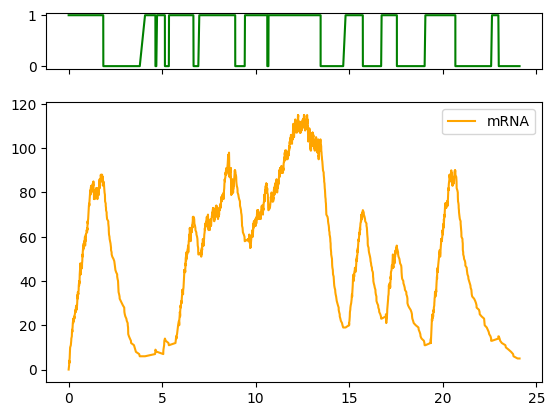

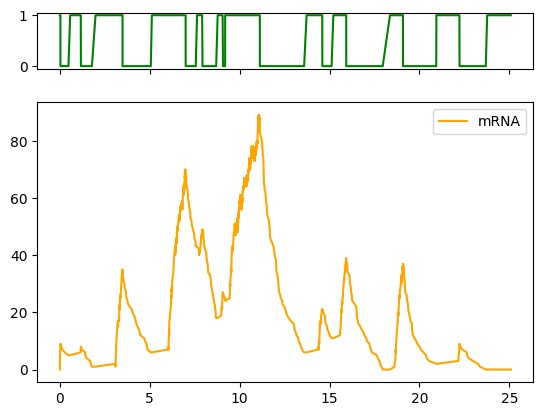

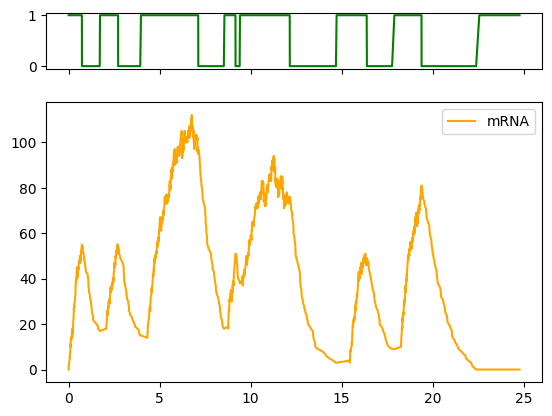

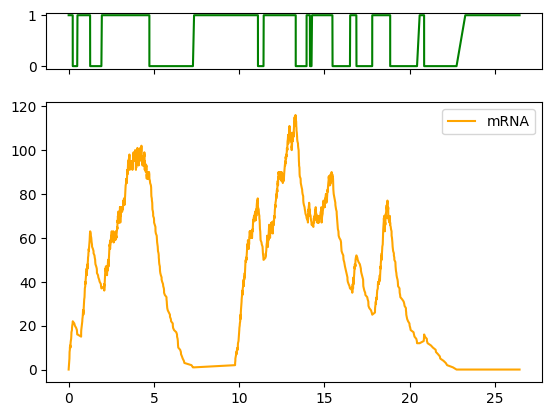

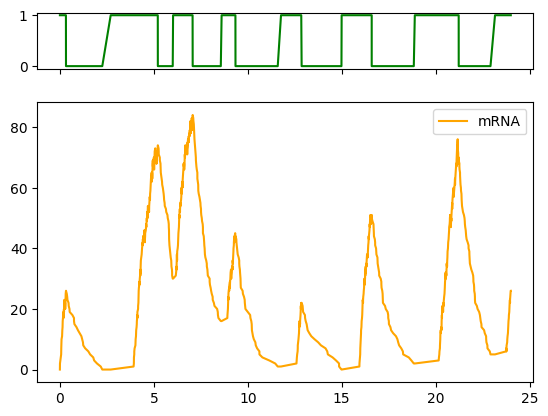

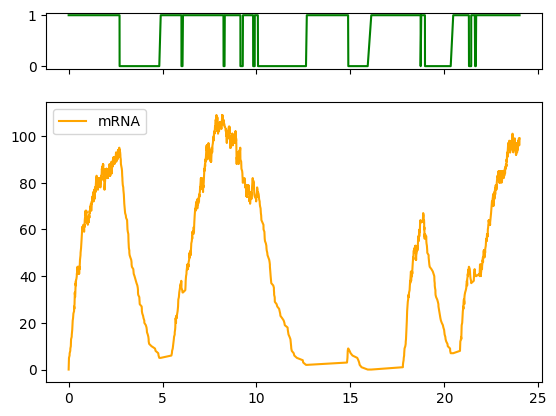

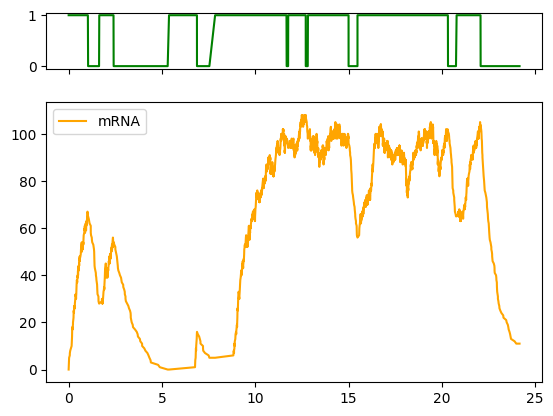

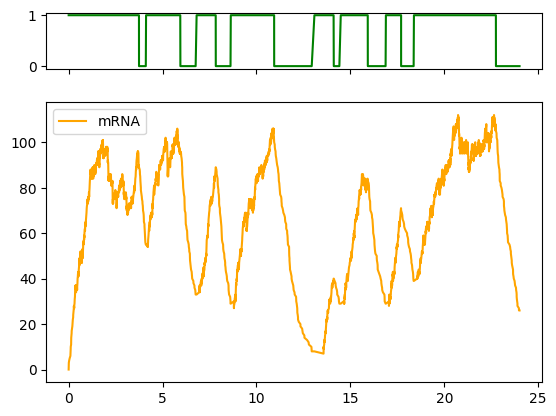

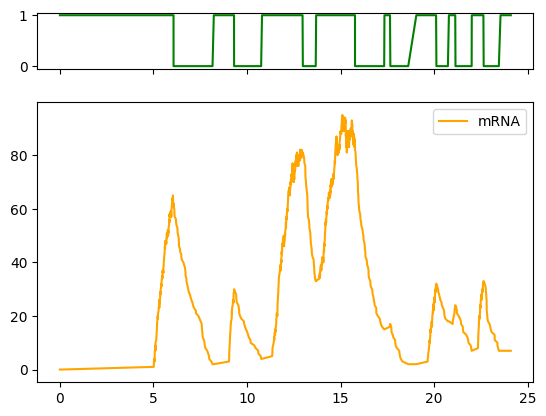

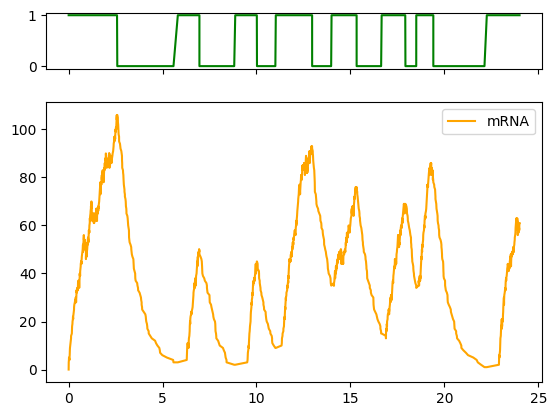

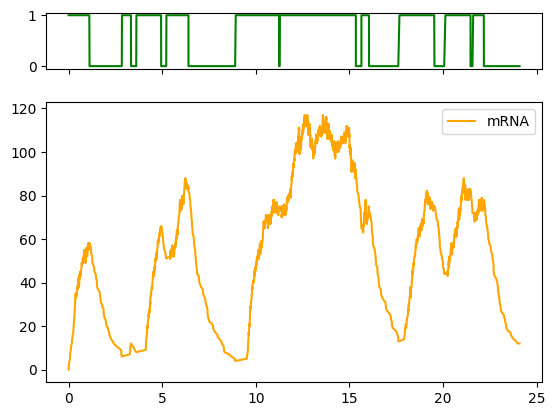

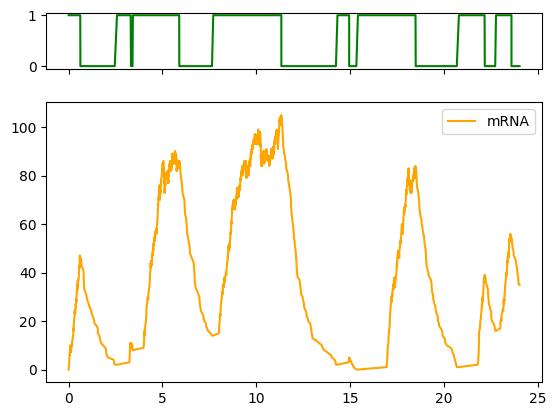

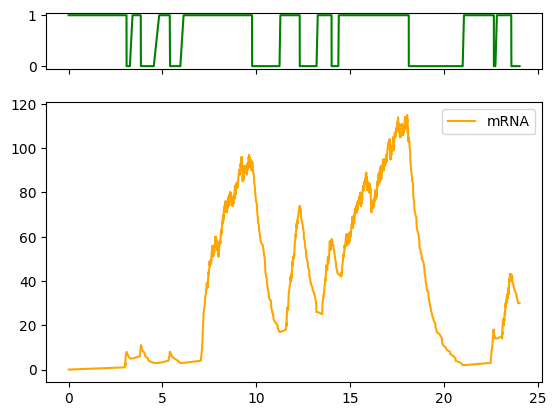

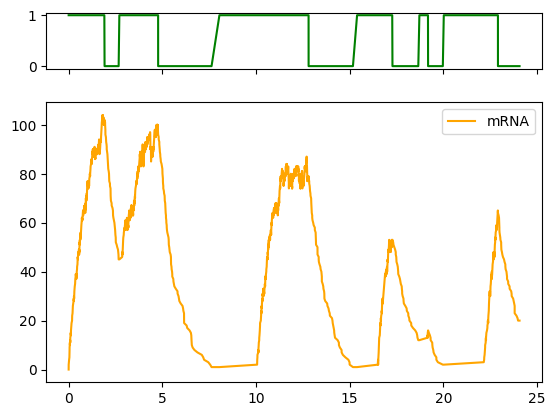

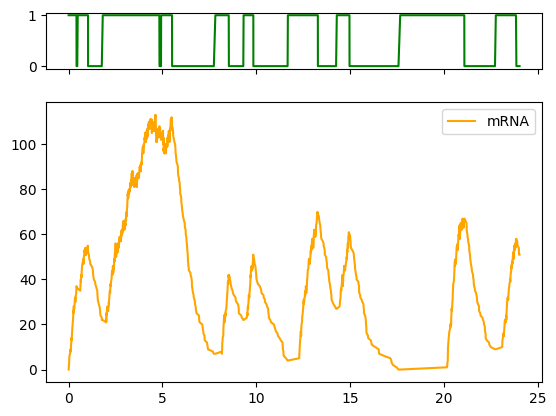

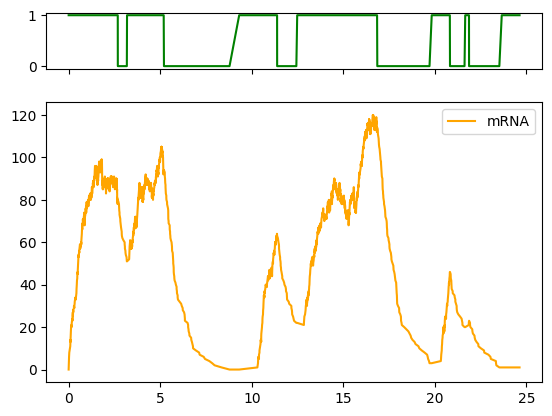

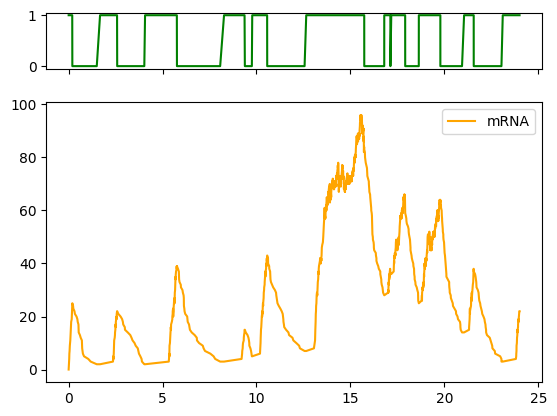

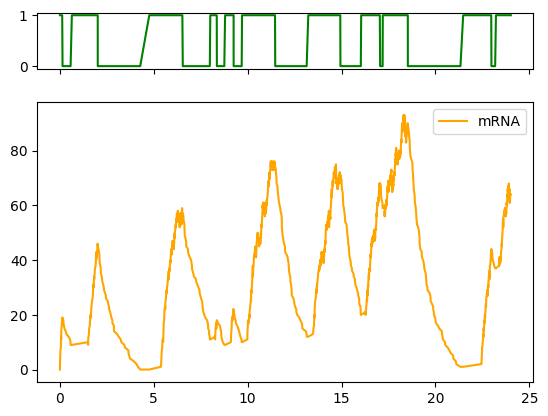

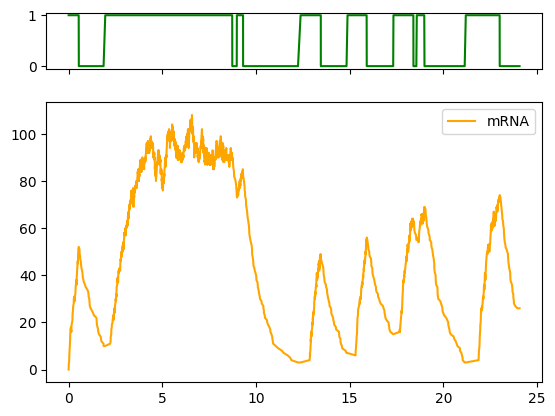

In [95]:
import matplotlib.pyplot as plt
mRNA_data = [data[i].data['mRNA'] for i in range(len(data))]
for i, mRNA in enumerate(mRNA_data):
    print(f"Shape of mRNA data for simulation {i}: {mRNA.shape}")

for i in range(0,len(data)):
    data_plt = data[i]
    fig, axs = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [1, 5]})
    ax = axs[0]
    ax.plot(data_plt.time, data_plt.data['ON'], c = 'green')
    
    ax = axs[1]
    # ax.plot(data_plt.time, data_plt.data['Tat'])
    ax.plot(data_plt.time, data_plt.data['mRNA'], c = 'orange', label = 'mRNA')
    ax.legend()

    
    plt.show()

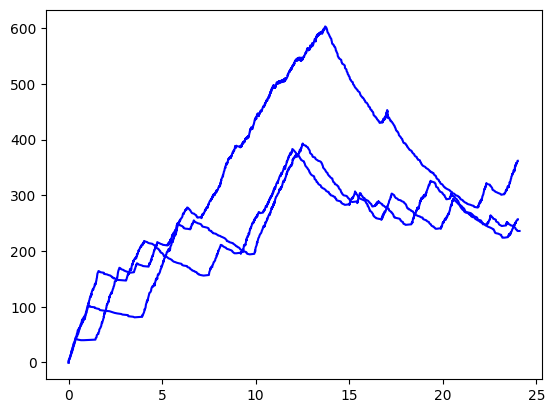

In [31]:
fig, ax = plt.subplots()

for i in range(0,len(data)):
    
    data_plt = data[i]
    ax.plot(data_plt.time, data_plt.data['mRNA'], c = 'blue', label = 'mRNA')


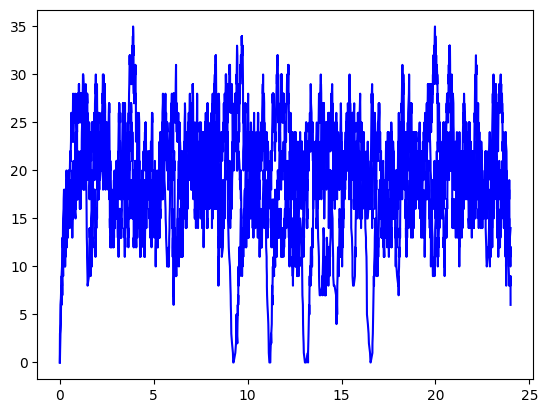

In [28]:
fig, ax = plt.subplots()

for i in range(0,len(data)):
    
    data_plt = data[i]
    ax.plot(data_plt.time, data_plt.data['mRNA'], c = 'blue', label = 'mRNA')